# Navigating Combinatorial Explosion with SMACT

In this notebook, we'll explore the scale of chemical space and learn how to navigate it efficiently using SMACT. We'll:

1. **Visualise** the combinatorial explosion
2. **Calculate** the number of possible materials
3. **Apply** chemical filters to find viable candidates
4. **Generate** practical composition lists for further study

Let's begin by understanding the vastness of chemical space.

## Part 1: The Mathematics of Combinatorial Explosion

The sheer scale of chemical space is mind-boggling. Let's start with pure mathematics to understand the problem before we apply chemistry. 

This section contains **ZERO** chemistry - it's a mathematical exercise to demonstrate the scale we're dealing with. The numbers we'll calculate match roughly those in Table 1 of the publication [\"Computational Screening of All Stoichiometric Inorganic Materials\"](https://www.cell.com/chem/fulltext/S2451-9294(16)30155-3) by Davies et al. (Chem, 2016).

*Note: This calculation can take a minute or two for quaternary compounds on a typical computer.*"


Number of possible element combinations:
  Elements |    Combinations |   Scientific
---------------------------------------------
         1 |             103 |    1.030e+02
         2 |           5,253 |    5.253e+03
         3 |         176,851 |    1.769e+05
         4 |       4,421,275 |    4.421e+06
         5 |      87,541,245 |    8.754e+07
         6 |   1,429,840,335 |    1.430e+09
         7 |  19,813,501,785 |    1.981e+10


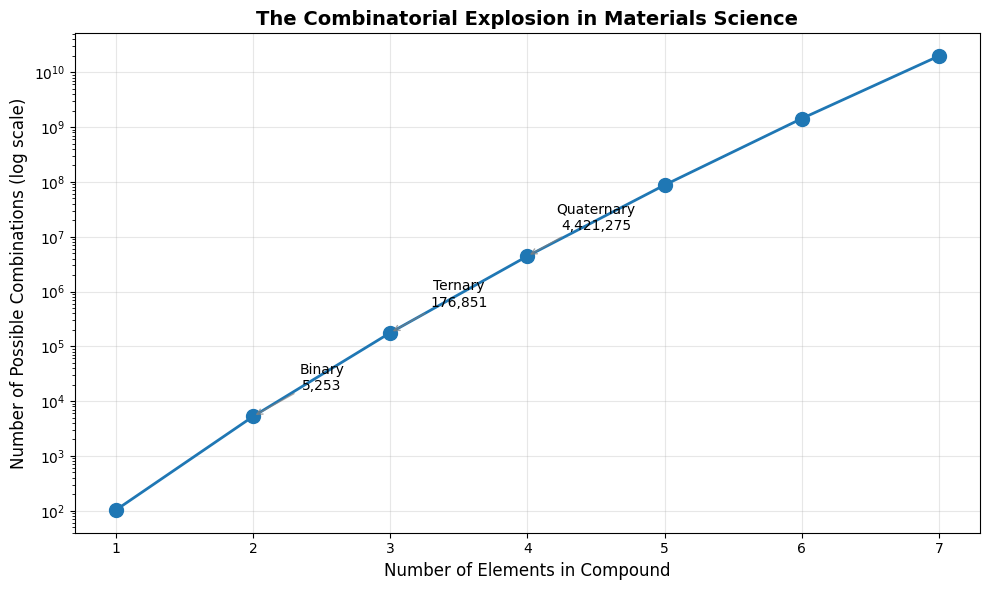

In [54]:
# Import required libraries
import itertools
from math import gcd, comb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# SMACT imports
import smact
from smact import Element, ordered_elements
from smact.screening import smact_filter

# For visualization
plt.style.use('default')
if 'seaborn' in plt.style.available:
    plt.style.use('seaborn-v0_8-darkgrid')


# First, let's see the scale of possible combinations
def count_combinations(n_elements, total_elements=103):
    """Calculate number of unique combinations of n elements."""
    return comb(total_elements, n_elements)

# Calculate combinations for different numbers of elements
n_elements_list = range(1, 8)
combinations_count = []

print("\nNumber of possible element combinations:")
print(f"{'Elements':>10} | {'Combinations':>15} | {'Scientific':>12}")
print("-" * 45)

for n in n_elements_list:
    count = count_combinations(n)
    combinations_count.append(count)
    print(f"{n:>10} | {count:>15,} | {count:>12.3e}")

# Visualize the explosion
plt.figure(figsize=(10, 6))
plt.semilogy(n_elements_list, combinations_count, 'o-', markersize=10, linewidth=2)
plt.xlabel('Number of Elements in Compound', fontsize=12)
plt.ylabel('Number of Possible Combinations (log scale)', fontsize=12)
plt.title('The Combinatorial Explosion in Materials Science', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add annotations for key points
for i, (n, count) in enumerate(zip([2, 3, 4], combinations_count[1:4])):
    name = ['Binary', 'Ternary', 'Quaternary'][i]
    plt.annotate(f'{name}\n{count:,.0f}', 
                xy=(n, count), 
                xytext=(n+0.5, count*3),
                fontsize=10,
                ha='center',
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7))

plt.tight_layout()
plt.show()

## Part 2: Stoichiometry: It Gets Worse!

So far we've only counted *element combinations*. But each combination can form multiple compounds with different stoichiometric ratios:

    - AB: one ratio
    - AB₂, A₂B: two more ratios 
    - AB₃, A₃B, A₂B₃, A₃B₂: four more ratios 

Let's see how this multiplies our already enormous numbers.

In [55]:
def count_stoichiometries(n_elements, max_coefficient=8):
    """Count possible stoichiometric ratios for n elements up to max_coefficient"""
    def is_irreducible(stoichs):
        """Check if stoichiometry can be reduced to smaller integers"""
        for i in range(1, len(stoichs)):
            if gcd(stoichs[i - 1], stoichs[i]) == 1:
                return True
        return False
    
    count = sum(1 for combo in itertools.product(
        *(n_elements * (tuple(range(1, max_coefficient + 1)),))
    ) if is_irreducible(combo))
    
    return count

# Example usage
n_elements = 3  # ternary compounds
max_coeff = 8
count = count_stoichiometries(n_elements, max_coeff)
print(f"Number of possible stoichiometries: {count}")

Number of possible stoichiometries: 433


## Part 3: From Astronomical to Practical - Enter SMACT!

The numbers above are overwhelming, but here's the good news: **most combinations are chemically impossible**.

SMACT applies chemical rules to filter out:
- Impossible oxidation states (like Na⁻⁵)
- Combinations that violate charge neutrality 
- Elements that don't typically bond together

Let's see this filtering in action with real elements:

In [56]:
# Let's work with a manageable set: first-row transition metals
from smact import Element, element_dictionary, ordered_elements
from smact.screening import smact_filter
import multiprocessing
from datetime import datetime

def generate_viable_compositions(elements, n_elements=3):
    """Generate chemically viable compositions using SMACT filters."""
    # Create element combinations
    element_combos = itertools.combinations(elements, n_elements)
    # We need to pass Element objects to smact_filter, not just symbols
    systems = [[Element(symbol) for symbol in combo] for combo in element_combos]
    
    print(f"Processing {len(systems)} {n_elements}-element combinations...")
    
    # Apply SMACT filtering in parallel for speed
    with multiprocessing.Pool(processes=min(4, multiprocessing.cpu_count())) as pool:
        results = pool.map(smact_filter, systems)
    
    # Flatten results and count
    compositions = [item for sublist in results for item in sublist if sublist]
    return compositions

# Example: First-row transition metals (Sc to Zn)
# Just use the symbols directly, will convert to Element objects in generate_viable_compositions
transition_metals = ordered_elements(21, 30)
print(f"Working with transition metals: {', '.join(transition_metals)}")

# Raw combinations
raw_ternary = comb(len(transition_metals), 3)
print(f"\nRaw ternary combinations: {raw_ternary:,}")

# Apply SMACT filtering
viable_compositions = generate_viable_compositions(transition_metals, n_elements=3)
print(f"Viable ternary compositions: {len(viable_compositions):,}")
if len(viable_compositions) > 0:
    print(f"Reduction factor: {raw_ternary/len(viable_compositions):.1f}x")
print("\nSMACT has reduced our search space dramatically!")

Working with transition metals: Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn

Raw ternary combinations: 120
Processing 120 3-element combinations...


Viable ternary compositions: 1,407
Reduction factor: 0.1x

SMACT has reduced our search space dramatically!


## Part 4: Practical Results - Real Material Formulas

Let's convert our filtered compositions into readable chemical formulas and see what we've found:

In [57]:
import pandas as pd

def format_compositions(compositions):
    """Convert SMACT compositions to readable formulas."""
    formulas = []
    for comp in compositions:
        elements, oxidations, stoichs = comp
        # Create formula string
        formula_parts = []
        for el, stoich in zip(elements, stoichs):
            if stoich == 1:
                formula_parts.append(el)
            else:
                formula_parts.append(f"{el}{stoich}")
        formula = ''.join(formula_parts)
        formulas.append(formula)
    
    return formulas

# Convert to readable formulas
if len(viable_compositions) > 0:
    formulas = format_compositions(viable_compositions)
    df_results = pd.DataFrame({"formula": formulas}).drop_duplicates()
    
    print(f"\nGenerated {len(df_results)} unique transition metal compounds:")
    print("\nSample formulas:")
    for i, formula in enumerate(df_results['formula'].head(15)):
        print(f"  {i+1:2d}. {formula}")
    
    if len(df_results) > 15:
        print(f"  ... and {len(df_results) - 15} more!")
else:
    print("\nNo viable compositions found with these elements.")
    print("This demonstrates how restrictive chemical rules can be!")


Generated 1016 unique transition metal compounds:

Sample formulas:
   1. ScTiMn3
   2. ScTi2Mn5
   3. ScTi3Mn7
   4. Sc2TiMn4
   5. Sc2Ti3Mn8
   6. Sc3TiMn5
   7. Sc3Ti2Mn7
   8. Sc4TiMn6
   9. Sc5TiMn7
  10. Sc6TiMn8
  11. ScTiMn4
  12. ScTi2Mn7
  13. Sc2TiMn5
  14. Sc3TiMn6
  15. Sc4TiMn7
  ... and 1001 more!


In [58]:
# Some statistics
if len(viable_compositions) > 0:
    print(f"\n **Key Results:**")
    print(f"- Started with {raw_ternary:,} possible combinations")
    print(f"- SMACT filtered to {len(viable_compositions):,} viable compositions")
    print(f"- This gives us {len(df_results)} unique material formulas")
    print(f"- Reduction factor: **{raw_ternary/len(viable_compositions):.0f}x smaller search space**")
    
    print(f"\n **The Power of Informatics:**")
    print(f"Instead of testing {raw_ternary:,} combinations randomly,")
    print(f"we can focus on {len(df_results)} promising candidates!")


 **Key Results:**
- Started with 120 possible combinations
- SMACT filtered to 1,407 viable compositions
- This gives us 1016 unique material formulas
- Reduction factor: **0x smaller search space**

 **The Power of Informatics:**
Instead of testing 120 combinations randomly,
we can focus on 1016 promising candidates!


## Part 5: Exploring Different Chemical Spaces

Let's now explore what happens when we include oxygen - suddenly we're looking at oxides!

In [59]:
# Let's add oxygen to our transition metals
elements_with_oxygen = transition_metals + ['O']
print(f"Elements: {', '.join(elements_with_oxygen)}")

# Generate binary oxides
binary_oxides = []
for metal in transition_metals:
    # Use Element objects for smact_filter (Element class already imported at top)
    metal_obj = Element(metal)
    oxygen_obj = Element('O')
    binary_result = smact_filter([metal_obj, oxygen_obj])
    if binary_result:
        binary_oxides.extend(binary_result)

print(f"\nFound {len(binary_oxides)} binary transition metal oxides:")

# Show some examples
if len(binary_oxides) > 0:
    oxide_formulas = format_compositions(binary_oxides[:10])
    for i, formula in enumerate(oxide_formulas):
        print(f"  {formula}")
    
    print(f"\n💡 Notice how adding just one element (oxygen) opens up many new possibilities!")
else:
    print("No binary oxides found!")

Elements: Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, O

Found 86 binary transition metal oxides:
  Sc2O
  ScO
  ScO
  ScO2
  Sc2O3
  ScO3
  TiO
  TiO2
  Ti2O3
  TiO3

💡 Notice how adding just one element (oxygen) opens up many new possibilities!


## Summary and Next Steps

In [60]:
print(f"\n🚀 **What We've Learned:**")
print(f"• Chemical space contains **trillions** of possible materials")
print(f"• Most combinations are chemically **impossible**")
print(f"• SMACT filters reduce the space by **orders of magnitude**")
print(f"• We can generate **focused lists** of viable candidates")

print(f"\n📖 **Coming Up Next:**")
print(f"• Apply enhanced chemical filters")
print(f"• Screen for specific material properties")
print(f"• Predict crystal structures for our candidates")
print(f"• Use AI to explore even larger chemical spaces")

print(f"\n💡 **Try This:**")
print(f"• Change the element list to include sulfur or halogens")
print(f"• Try binary or quaternary compositions")
print(f"• Filter for specific oxidation state patterns")
print(f"• Export results for use in other tutorials")


🚀 **What We've Learned:**
• Chemical space contains **trillions** of possible materials
• Most combinations are chemically **impossible**
• SMACT filters reduce the space by **orders of magnitude**
• We can generate **focused lists** of viable candidates

📖 **Coming Up Next:**
• Apply enhanced chemical filters
• Screen for specific material properties
• Predict crystal structures for our candidates
• Use AI to explore even larger chemical spaces

💡 **Try This:**
• Change the element list to include sulfur or halogens
• Try binary or quaternary compositions
• Filter for specific oxidation state patterns
• Export results for use in other tutorials


## Exercise: Your Turn!

Now it's your turn to explore chemical space. Try these challenges:

1. **Alkali Metal Oxides**: Generate all possible oxides of Li, Na, K
2. **Perovskites**: Find all ABX₃ compounds where A=alkaline earth, B=transition metal, X=O
3. **Large Scale**: How many viable quaternary compounds can you find with common elements?"

In [61]:
# Space for your experiments
# Example: Alkali metal oxides

# Your code here..."